In [1]:
# Summary -
# Builds visualization of the rico dataset. You can visualize an entire
# trace (multiple screenshots) with a matplotlib image plots.

In [2]:
# import statements.
import glob
import json
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import seaborn as sbs

In [3]:
BUCKET_NAME = 'rico_dataset'
LONG_TOUCH_THRESHOLD = 5
SWIPE_THRESHOLD = 10
DIM_X = 1440
DIM_Y = 2560
TRACES_PATH = 'filtered_traces/*/*'

In [ ]:
# Download file and upload extracted zip file to gcs.
# Commented out to not run multiple times.
! wget https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/traces.tar.gz
# ! gsutil mb gs://$BUCKET_NAME
# ! gsutil cp traces.tar.gz gs://$BUCKET_NAME/10GB.zip
! tar -xvf traces.tar.gz
# ! gsutil -m cp -r filtered_traces gs://$BUCKET_NAME

--2021-01-02 06:43:05--  https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/traces.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6796851860 (6.3G) [application/gzip]
Saving to: ‘traces.tar.gz’

traces.tar.gz        63%[===========>        ]   4.00G   116MB/s    eta 23s    

In [12]:
# Inspired from humanoid - https://github.com/yzygitzh/Humanoid/blob/master/rico/touch_input.py#L11

# Gets all leaf nodes for a given element.
def get_leaf_nodes(element, leaf_nodes):
    if not element:
        return leaf_nodes
    if 'children' not in element:
        leaf_nodes.append(element)
        return leaf_nodes
    for child in element['children']:
        get_leaf_nodes(child, leaf_nodes)
    return leaf_nodes


def get_all_leaf_nodes(view_hierarchy_json):
    activity = view_hierarchy_json.get('activity')
    if not activity:
        return dataset
    root = activity.get('root')
    return get_leaf_nodes(root, [])


def get_leaf_node_texts(leaf_nodes):
    element_texts = []
    for leaf_node in leaf_nodes:
        if 'text' in leaf_node:
            text = leaf_node['text'] or leaf_node.get('text-hint')
            element_texts.append(str(text))
    return element_texts


# Identifies if a given gesture is a TOUCH gesture.
# In this task, we will only be focussing on TOUCH gestures.
def is_touch_gesture(gesture):
    if len(gesture) <= LONG_TOUCH_THRESHOLD:
        return True
    return False

In [15]:
# Get distribution of leaf node texts.
text_data = []
for trace_path in sorted(glob.glob(TRACES_PATH)):
    view_hierarchies_path = f'{trace_path}/view_hierarchies/*'
    view_hierarchies = sorted(glob.glob(view_hierarchies_path))
    for view_hierarchy_path in view_hierarchies:
        with open(view_hierarchy_path) as file:
            view_hierarchy_json = json.load(file)
            if not view_hierarchy_json:
                continue
            leaf_nodes = get_all_leaf_nodes(view_hierarchy_json)
            leaf_node_texts = get_leaf_node_texts(leaf_nodes)
            text_data.append(len(leaf_node_texts))

<AxesSubplot:ylabel='Count'>

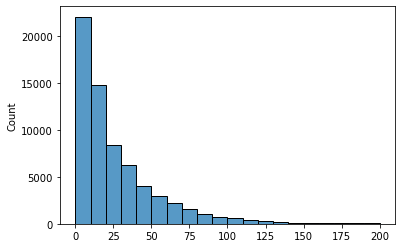

In [14]:
# tf.summary.histogram('Name', text_data)
sbs.histplot(text_data, binrange=[0, 200], binwidth=10)
# np.average(text_data)

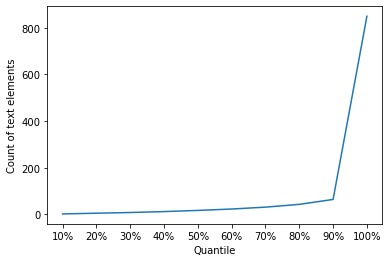

In [246]:
quantile_x = []
quantile_y = []
for i in range(1, 11):
    quantile_x.append(f'{i*10}%')
    quantile_y.append(np.quantile(text_data, i/10))
ax = sbs.lineplot(x=quantile_x, y=quantile_y)
ax.set(xlabel='Quantile', ylabel='Count of text elements')
plt.show()

In [207]:
dirs = glob.glob("filtered_traces/*/*")
touch_gesture_count = 0
non_touch_gesture_count = 0
for d in dirs:
  with open(f'{d}/gestures.json') as f:
    gestures = json.load(f)
    gestures = [gestures[x] for x in sorted(gestures, key=lambda x: int(x))]
    for gesture in gestures:
        if is_touch_gesture(gesture):
            touch_gesture_count += 1
        else:
            non_touch_gesture_count += 1
print('Number of touch gestures ', touch_gesture_count)
print('Number of non-touch gestures ', non_touch_gesture_count)

Number of touch gestures  59602
Number of non-touch gestures  6659


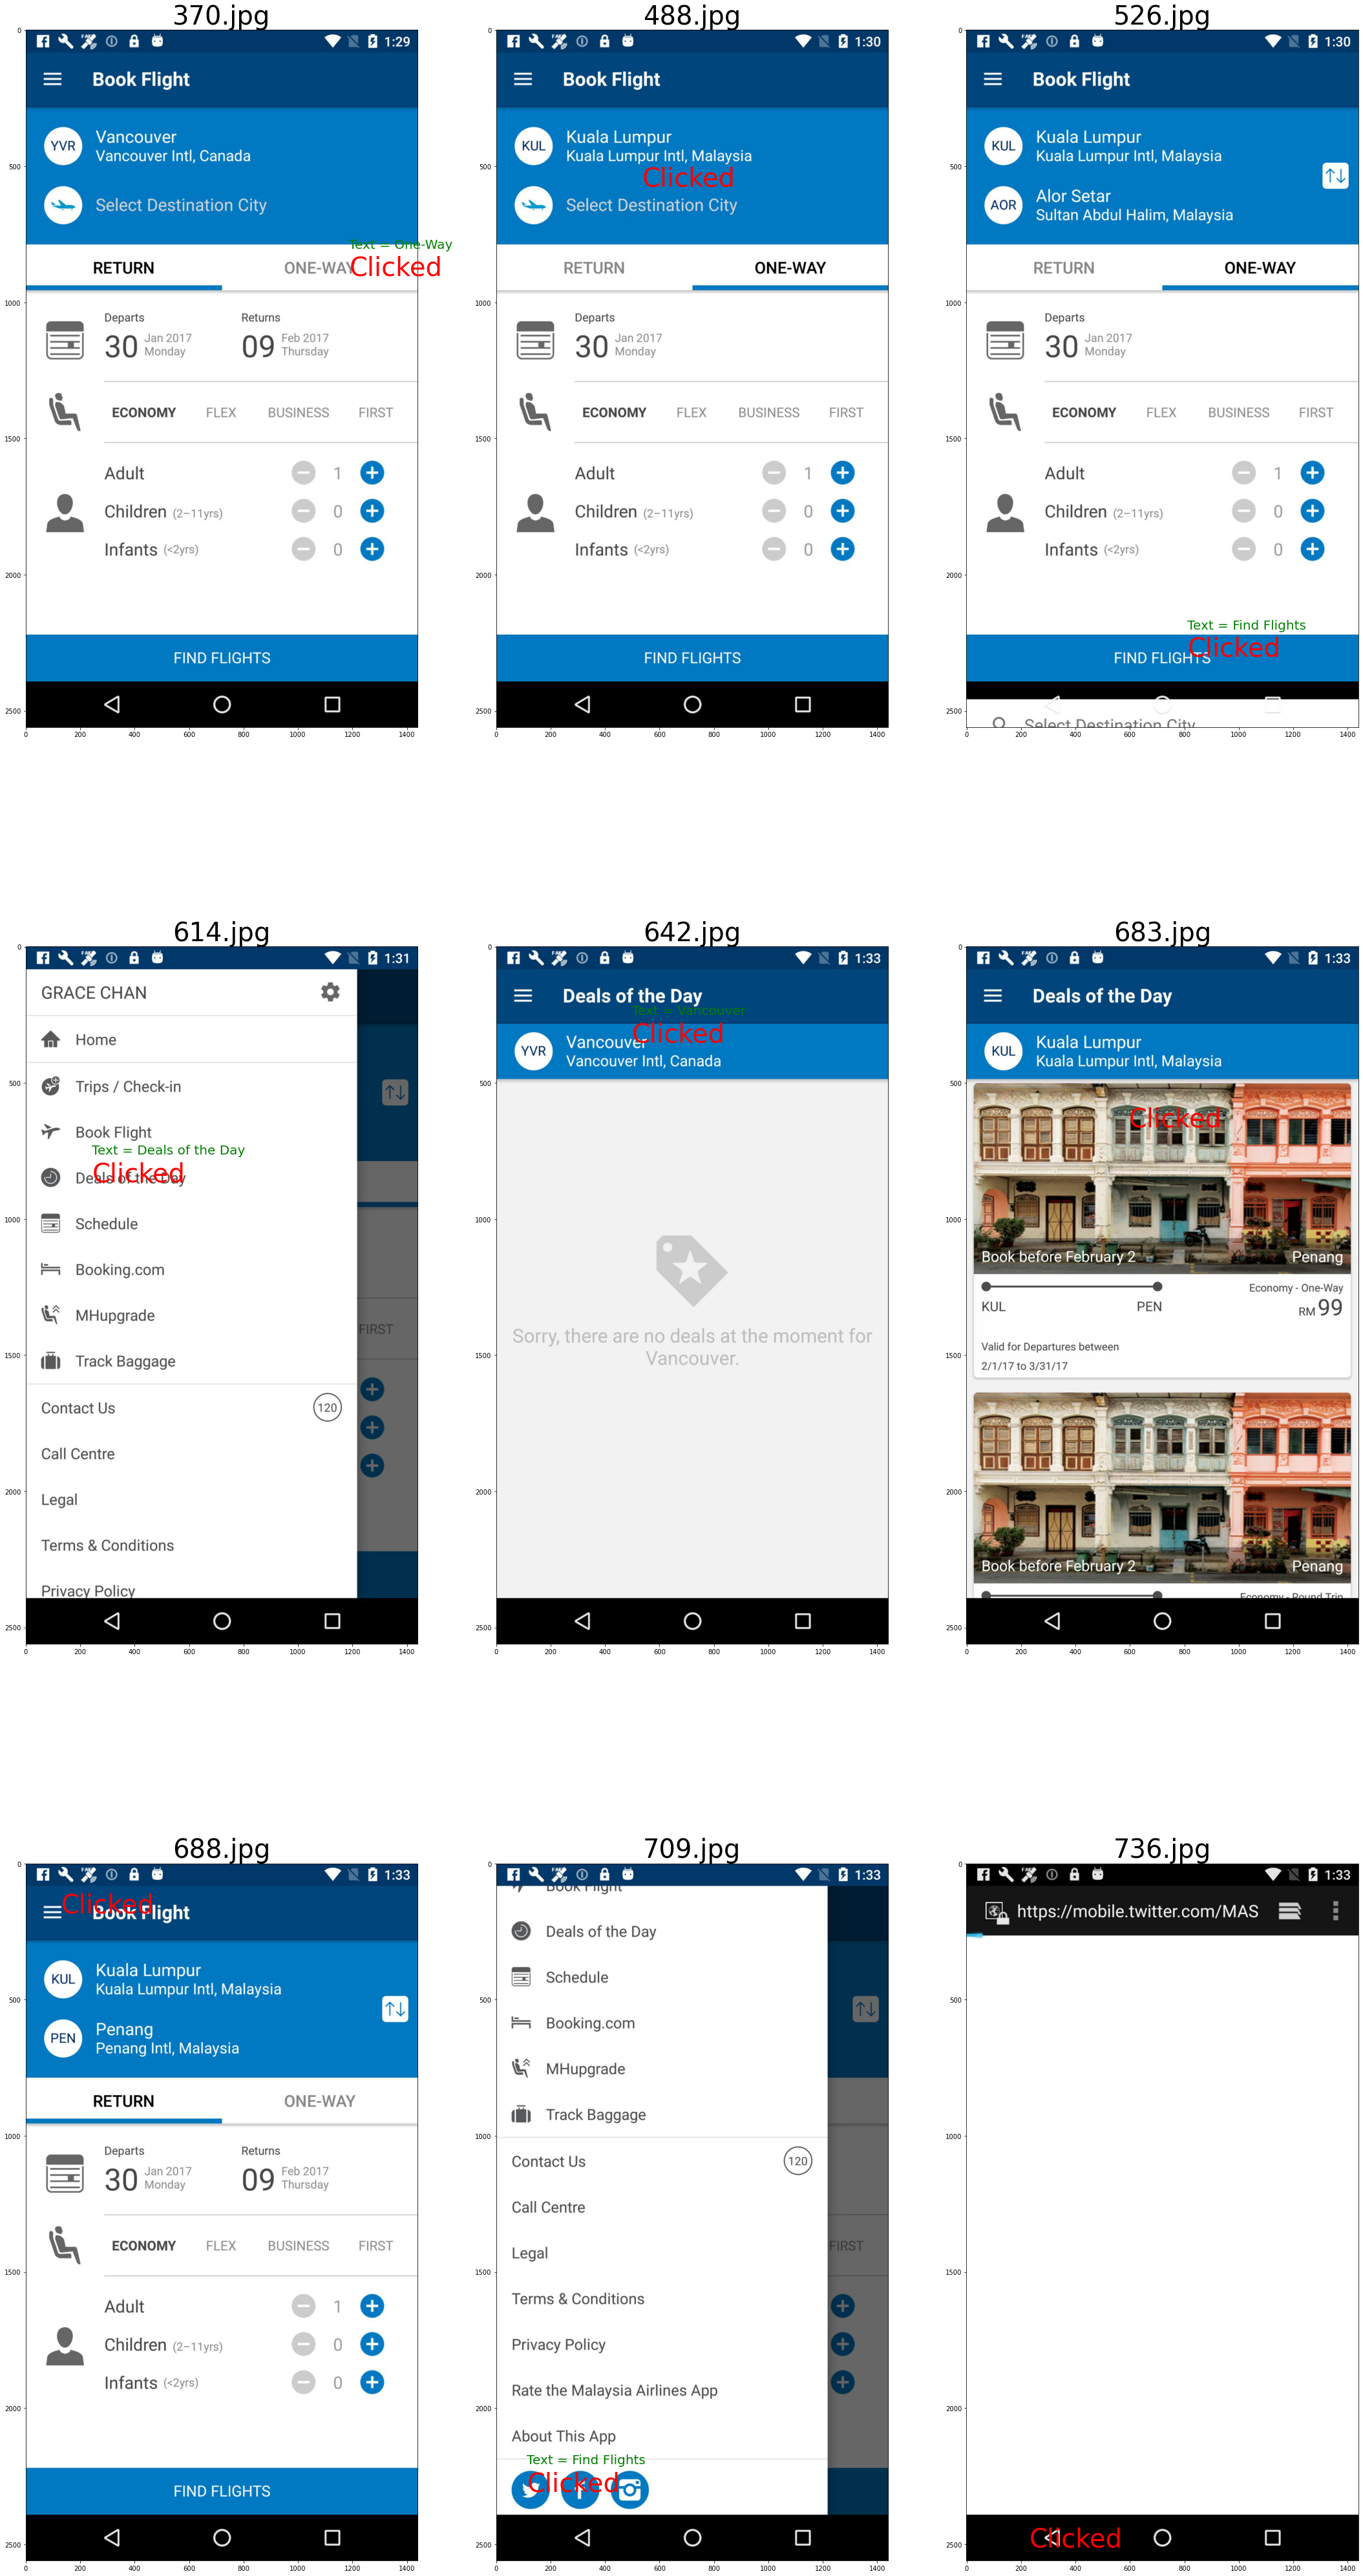

In [17]:
# Single Trace Visualization.

from PIL import Image

trace_path = 'filtered_traces/aero.sita.lab.resmobileweb.android.mh/trace_0'
view_hierarchies_path = f'{trace_path}/view_hierarchies'
screenshots_path = f'{trace_path}/screenshots'
gestures_path = f'{trace_path}/gestures.json'

with open(gestures_path) as file:
    gestures = json.load(file)

valid_screenshots = []
for file in os.listdir(screenshots_path):
    ui_number = file.split('.')[0]
    try:
        int(ui_number)
    except ValueError:
        continue
    gesture = gestures[ui_number]
    if not is_touch_gesture(gesture):
        continue
    valid_screenshots.append((ui_number, file))

rows = int(len(valid_screenshots) / 3) + 1
fig, axs = plt.subplots(rows, rows, figsize=(50,100))
for i in range(rows):
    for j in range(rows):
        axs[i, j].set_visible(False)  # Initalize all the plots to be invisible.

def get_leaf_nodes(element, leaf_nodes):
    if 'children' not in element:
        leaf_nodes.append(element)
        return leaf_nodes
    for child in element['children']:
        get_leaf_nodes(child, leaf_nodes)
    return leaf_nodes

for index, (ui_number, file) in enumerate(sorted(valid_screenshots)):
    gesture = gestures[ui_number]
    x_cord = gesture[0][0]
    y_cord = gesture[0][1]
    
    # Plot the screenshot with position where click(tap) was performed.
    screenshot = PIL.Image.open(f'{screenshots_path}/{file}')
    # The size of the screenshot is 1080 * 1920.
    # Rescaling it to 1440 * 2560, dimension used by view hierarchy data.
    resized_img = screenshot.resize((DIM_X, DIM_Y), Image.ANTIALIAS)

    row = int(index / 3)
    col = int(index % 3)
    x = x_cord * DIM_X
    y = y_cord * DIM_Y
    axs[row, col].imshow(resized_img)
    axs[row, col].annotate('Clicked', fontsize=40, xy=(x, y), color='red')
    axs[row, col].set_title(file, {'fontsize': 40})
    axs[row, col].set_visible(True)
    
    view_hierarchy_json_path = f'{view_hierarchies_path}/{ui_number}.json'
    with open(view_hierarchy_json_path) as file:
        view_hierarchy_json = json.load(file)    
    root = view_hierarchy_json['activity']['root']
    leaf_nodes = get_leaf_nodes(root, [])
    # Annotating text of the element clicked from view hierarchy data.
    for leaf_node in leaf_nodes:
        bounds = leaf_node['bounds']
        if bounds[0] <= x and bounds[2] >= x and bounds[1] <= y and bounds[3] >= y:
            if 'text' in leaf_node:
                text = leaf_node['text'] or leaf_node['text-hint']
                axs[row, col].annotate(f'Text = {text}', fontsize=20, xy=(x, y - 100), color='green')

plt.show()